# Deep Q-Learning Applied to Algorithmic Trading

<a href="https://www.kaggle.com/code/addarm/deep-q-rl-with-algorithmic-trading-policy" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


<a href="https://colab.research.google.com/drive/1FTj65b2DA8oFgvmmjLc0XIwtII32PwcM?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


INTRO


This deep learning network was inspired by the paper:
```BibTeX
@article{theate2021application,
  title={An application of deep reinforcement learning to algorithmic trading},
  author={Th{\'e}ate, Thibaut and Ernst, Damien},
  journal={Expert Systems with Applications},
  volume={173},
  pages={114632},
  year={2021},
  publisher={Elsevier}
}
```

In [1]:
try:
  import google.colab

  !sudo apt-get update
  !sudo apt-get install -y xvfb freeglut3-dev
  !pip install pyvirtualdisplay
  !pip install tf-agents[reverb]
  !pip install pyglet
  !pip install tf-keras
  !pip install shutil

  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
  files = None

In [2]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1' # KERAS 2 only for tfagents
import warnings
warnings.filterwarnings("ignore")
import shutil

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'
if IN_COLAB or IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle or Collab...')
    %pip install scikit-learn
    %pip install tensorflow
    %pip install tqdm
    %pip install matplotlib
    %pip install python-dotenv
    %pip install yfinance
    %pip install pyarrow
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

    DATA_DIR = "/kaggle/input/DATASET"
else:
    DATA_DIR = "./data/"
    print('Running Local...')

Running Local...


In [3]:
START_DATE = "2017-01-01"
SPLIT_DATE = '2018-1-1' # Turning point from train to tst
END_DATE = "2019-12-31" # pd.Timestamp(datetime.now() - BDay(1)).strftime('%Y-%m-%d')
DATA_DIR = "./data"
INDEX = "Date"
TARGET = 'TSLA'
TICKER_SYMBOLS = [TARGET]
INTERVAL = "1d"

MODELS_PATH = './models'
LOGS_PATH = './logs'

ACT_NEUTRAL = 3 # Added this action to go to neutral and wait
ACT_LONG = 2
ACT_HOLD = 1
ACT_SHORT = 0

CAPITAL = 100000
TRADE_COSTS_PERCENT = 0.1 / 100

FEATURES = ["Close", "High", "Low", "Open", "Volume"]
TARGET_FEATURE = "Price Raw"
STATE_LEN = 1
OBS_SPACE = (STATE_LEN)*len(FEATURES)
ACT_SPACE = 2

BATCH_SIZE = OBS_SPACE * 1000
LEARN_RATE = 1e-3
TOTAL_ITERS = 10 # 10000
EPISODES = 10
INIT_COLLECT =10  # 100
TOTAL_COLLECT = 1
LOG_INTERVALS = 20 # 200
TEST_INTERVALS = 10 # 1000
MEMORY_LENGTH = OBS_SPACE * 100
DISCOUNT = 0.4
EPSILON_START = 1.
EPSILON_END = 0.01
EPSILON_DECAY = 10000
ALPHA = 0.1
L2Factor = 0.000001
NEURONS = 512
LAYERS = (NEURONS, NEURONS//2, NEURONS//4)

# Financial Data

In [4]:
import numpy as np
import math
import shutil
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from datetime import datetime
from pandas.tseries.offsets import BDay

from scipy.stats import skew, kurtosis

import tensorflow as tf
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.utils import common
from tf_agents.metrics import tf_metrics
from tf_agents.eval import metric_utils
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym, py_environment, tf_py_environment, utils
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy, policy_saver, random_tf_policy

import reverb
from tf_agents.replay_buffers import reverb_replay_buffer, reverb_utils

os.getcwd()

2024-03-12 15:25:51.091033: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 15:25:51.091119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 15:25:51.092699: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 15:25:51.104727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 15:25:52.345603: W tensorflow/compiler/tf2

'/mnt/c/Users/adamd/workspace/deep-reinforced-learning'

In [5]:
def get_tickerdata(tickers_symbols, start=START_DATE, end=END_DATE, interval=INTERVAL, datadir=DATA_DIR):
    tickers = {}
    earliest_end= datetime.strptime(end,'%Y-%m-%d')
    latest_start = datetime.strptime(start,'%Y-%m-%d')
    os.makedirs(DATA_DIR, exist_ok=True)
    for symbol in tickers_symbols:
        cached_file_path = f"{datadir}/{symbol}-{start}-{end}-{interval}.csv"

        try:
            if os.path.exists(cached_file_path):
                df = pd.read_parquet(cached_file_path)
                df.index = pd.to_datetime(df.index)
                assert len(df) > 0
            else:
                df = yf.download(
                    symbol,
                    start=START_DATE,
                    end=END_DATE,
                    progress=False,
                    interval=INTERVAL,
                )
                assert len(df) > 0
                df.to_parquet(cached_file_path, index=True, compression="snappy")
            min_date = df.index.min()
            max_date = df.index.max()
            nan_count = df["Close"].isnull().sum()
            skewness = round(skew(df["Close"].dropna()), 2)
            kurt = round(kurtosis(df["Close"].dropna()), 2)
            outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
            print(
                f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
            )
            tickers[symbol] = df

            if min_date > latest_start:
                latest_start = min_date
            if max_date < earliest_end:
                earliest_end = max_date
        except Exception as e:
            print(f"Error with {symbol}: {e}")

    return tickers, latest_start, earliest_end

tickers, latest_start, earliest_end = get_tickerdata(TICKER_SYMBOLS)
tickers[TARGET]

TSLA => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.56, skewness:-0.28, outliers_count:0,  nan_count: 0


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500
2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500
2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500
2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500
2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500
...,...,...,...,...,...,...
2019-12-23,27.452000,28.134001,27.333332,27.948000,27.948000,199794000
2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500
2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500


# Trading Environment

In [6]:
class TradingEnv(py_environment.PyEnvironment):
    """
    A custom trading environment for reinforcement learning, compatible with tf_agents.

    This environment simulates a simple trading scenario where an agent can take one of three actions:
    - Long (buy), Short (sell), or Hold a financial instrument, aiming to maximize profit through trading decisions.

    Parameters:
    - data: DataFrame containing the stock market data.
    - data_dim: Dimension of the data to be used for each observation.
    - money: Initial capital to start trading.
    - state_length: Number of past observations to consider for the state.
    - transaction_cost: Costs associated with trading actions.
    """

    def __init__(self, data, features = FEATURES, money=CAPITAL, state_length=STATE_LEN, transaction_cost=0, market_costs=TRADE_COSTS_PERCENT):
        super(TradingEnv, self).__init__()

        assert data is not None

        self.features = features
        self.data_dim = len(self.features)
        self.current_step = 0

        self.balance = money
        self.initial_balance = money
        self.transaction_cost = transaction_cost
        self.epsilon = max(market_costs, np.finfo(float).eps) # there is always volatility costs
        self.total_shares = 0

        self.state_length = state_length
        self._episode_ended = False
        self._batch_size = 1
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=ACT_SHORT, maximum=ACT_LONG, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.data_dim,), dtype=np.float32, name='observation')

        self.data = self.preprocess_data(data.copy())

        self.reset()

    @property
    def batched(self):
        return False #True

    @property
    def batch_size(self):
        return None #self._batch_size

    @batch_size.setter
    def batch_size(self, size):
        self._batch_size = size

    def preprocess_data(self, df):
        def _log_rets(df):
            log_returns = np.log(df / df.shift(1))
            df = (log_returns - log_returns.mean()) / log_returns.std()
            df = df.dropna()
            return df

        price_raw = df['Close'].copy()
        df[self.features] = _log_rets(df[self.features])
        l = df[self.features]
        df = df.replace(0.0, np.nan)
        df = df.interpolate(method='linear', limit=5, limit_area='inside')
        df = df.ffill().bfill()

        df[TARGET_FEATURE] = price_raw
        df['Position'] = 0
        df['Action'] = ACT_HOLD
        df['Holdings'] = 0.
        df['Cash'] = float(self.balance)
        df['Money'] = df['Holdings'] + df['Cash']
        df['Returns'] = 0.

        assert not df.isna().any().any()

        return df

    def action_spec(self):
        """Provides the specification of the action space."""
        return self._action_spec

    def observation_spec(self):
        """Provides the specification of the observation space."""
        return self._observation_spec

    def _reset(self):
        """Resets the environment state and prepares for a new episode."""
        self.balance = self.initial_balance
        self.current_step = 0
        self._episode_ended = False
        self.total_shares = 0

        self.data['Position'] = 0
        self.data['Action'] = ACT_HOLD
        self.data['Holdings'] = 0.
        self.data['Cash']  = float(self.balance)
        self.data['Money'] = self.data.iloc[0]['Holdings'] + self.data.iloc[0]['Cash']
        self.data['Returns'] = 0.

        initial_observation = self._next_observation()
        return ts.restart(initial_observation)

    def _next_observation(self):
        """Generates the next observation based on the current step."""
        if self.current_step == 0 or self.state_length == 1:
            obs = self.data[self.features].iloc[0: self.current_step + 1]
        else:
            obs = self.data[self.features].iloc[min(0, self.current_step-self.state_length):self.current_step]
            assert len(obs) == self.state_length
        obs = obs.values[0]
        obs = obs.flatten().astype(np.float32)
        return obs

    def _step(self, action):
        """Executes a trading action and updates the environment's state."""
        if self._episode_ended:
            return self.reset()

        self.current_step += 1
        step_idx = self.data.index[self.current_step]
        current_price = self.data.iloc[self.current_step][TARGET_FEATURE]

        if self.current_step == 250 or  self.data.iloc[self.current_step].isna().any().any():
            assert not self.data.iloc[self.current_step].isna().any().any()

        if action == ACT_LONG:
            self._process_long_position(current_price)
        elif action == ACT_SHORT:
            prev_current_price = self.data.iloc[self.current_step - 1][TARGET_FEATURE]
            self._process_short_position(current_price, prev_current_price)
        elif action == ACT_HOLD:
            self._process_hold_position()
        elif action == ACT_NEUTRAL:
            self._process_neutral_position(current_price)
        else:
          raise Exception(f"Invalid Actions: {action}")

        self._update_financials(current_price)
        done = self.current_step >= len(self.data) - 1
        reward = self._calculate_reward()
        if done:
            self._episode_ended = True
            return ts.termination(self._next_observation(), reward)
        else:
            return ts.transition(self._next_observation(), reward)

    def _get_lower_bound(self, cash, total_shares, price):
        """
        Compute the lower bound of the action space, particularly for short selling,
        based on current cash, the number of shares, and the current price.
        """
        delta = -cash - total_shares * price * (1 + self.epsilon) * (1 + self.transaction_cost)

        if delta < 0:
            lowerBound = delta / (price * (2 * self.transaction_cost + self.epsilon * (1 + self.transaction_cost)))
        else:
            lowerBound = delta / (price * self.epsilon * (1 + self.transaction_cost))

        if np.isinf(lowerBound):
            assert False
        return lowerBound

    def _process_hold_position(self):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, "Cash"] = self.data.iloc[self.current_step - 1]["Cash"]
        self.data.at[step_idx, "Holdings"] = self.data.iloc[self.current_step - 1]["Holdings"]
        self.data.at[step_idx, "Position"] = self.data.iloc[self.current_step - 1]["Position"]
        self.data.at[step_idx, "Action"] = ACT_HOLD

    def _process_neutral_position(self, current_price):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, "Cash"] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
        self.data.at[step_idx, "Holdings"] = 0.0
        self.data.at[step_idx, "Position"] = 0.0
        self.data.at[step_idx, "Action"] = ACT_NEUTRAL

    def _process_long_position(self, current_price):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = 1
        if self.data.iloc[self.current_step - 1]['Position'] == 1:
            # more long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash']
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
        elif self.data.iloc[self.current_step - 1]['Position'] == 0:
            # new long
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
            self.data.at[step_idx, 'Action'] = 1
        else:
            # short to long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
            self.data.at[step_idx, 'Action'] = 1

    def _process_short_position(self, current_price, prev_price):
        """
        Adjusts the logic for processing short positions to include lower bound calculations.
        """
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = -1
        if self.data.iloc[self.current_step - 1]['Position'] == -1:
            # Short more
            low = self._get_lower_bound(self.data.iloc[self.current_step - 1]['Cash'], -self.total_shares, prev_price)
            if low <= 0:
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"]
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
            else:
                total_sharesToBuy = min(math.floor(low), self.total_shares)
                self.total_shares -= total_sharesToBuy
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] - total_sharesToBuy * current_price * (1 + self.transaction_cost)
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
        elif self.data.iloc[self.current_step - 1]['Position'] == 0:
            # new short
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
            self.data.at[step_idx, 'Action'] = -1
        else:
            # long to short
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
            self.data.at[step_idx, 'Action'] = -1

    def _update_financials(self, current_price):
        """Updates the financial metrics including cash, money, and returns."""
        step_idx = self.data.index[self.current_step]

        self.data.at[step_idx,'Money'] = self.data.iloc[self.current_step]['Holdings'] + self.data.iloc[self.current_step]['Cash']
        self.data.at[step_idx,'Returns'] = ((self.data.iloc[self.current_step]['Money'] - self.data.iloc[self.current_step - 1]['Money'])) / self.data.iloc[self.current_step - 1]['Money']

    def _calculate_reward(self, reward_clip=1000):
        """
        Calculates the reward for the current step.
        """
        return np.clip(self.data.iloc[self.current_step]['Returns'], -reward_clip, reward_clip)

    def render(self, mode='human'):
        print(f'Step: {self.current_step}, Balance: {self.balance}')

stock= tickers[TARGET]
train_data = stock[stock.index < pd.to_datetime(SPLIT_DATE)].copy()
test_data = stock[stock.index >= pd.to_datetime(SPLIT_DATE)].copy()

train_env = TradingEnv(train_data)
utils.validate_py_environment(train_env, episodes=EPISODES)
test_env = TradingEnv(test_data)
utils.validate_py_environment(train_env, episodes=EPISODES//4)

print(f"TimeStep Specs: {train_env.time_step_spec()}")
print(f"Action Specs: {train_env.action_spec()}")
print(f"Reward Specs: {train_env.time_step_spec().reward}")

time_step = train_env.reset()
print(f'Time step: {time_step}')
action = np.array(ACT_HOLD, dtype=np.int32)
next_time_step = train_env.step(action)
print(f'Next time step: {next_time_step}')

TimeStep Specs: TimeStep(
{'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(5,), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)})
Action Specs: BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=2)
Reward Specs: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Time step: TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([ 1.9550354 ,  1.6273892 ,  0.6523866 , -0.08771443,  1.6908462 ],
      dtype=float32)})
Next time step: TimeStep(
{'step_type': array(1, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'obse

# The Problem Definition

We are teaching an agent to trade in an environment with many unknowns. Our objective to make sequential interaction that lead to the highest sharpe ratio.

Let's formulize our policy, which is finding the optimal action *a_t* given state *s_t* to maximize our expected reward *r_t*:

$$
\pi^*(a_t | s_t) = \arg\max_{a \in \mathcal{A}} \mathbb{E} \left[ \sum_{t=0}^{\infty} \gamma^t r_t \middle| s_t = f(o_1, a_1, r_1, \ldots, o_t), a_t \right]
$$

At each timestep *t*:

1. Observe the environments state *s_t* and map history with *f(.)*
2. Observations *o_t* from history *h_t*, have previous actions *a_t-1*, previous observations *o_t-1* and their returns *r_t-1*. For our experiment, we'll encode these into features for a network.
3. Execute action *a_t*, which can be: hold, long, short
4. Get returns *r_t* discounted at *γ_t*. *γ* is the discounting factor to prevent the agent from doing only tactical choices for returns in the present (missing better future returns).


The *π(a_t|h_t)* creates an action on quantity *at = Qt*. Where a positive *Q* is the long, the negative *Q* signals a short and when its 0 no action is taken.


## Actions and Rewards

A core concept in RL is rewards engineering.

Let's look at our action space *A* at time *t*:

$$
a_t = Q_t \in \{Q_{\text{Long}, t}, Q_{\text{Short}, t}\}
$$

The action *Q_Long,t* is set to maximize returns on a buy, given our liquidity *vc_t* (the value *v* of our portfolio with cash remainng *c*) and purchasing *Q_long* at price *p* shares (transaction costs *C*) if we are not already long:

$$
Q_{\text{Long}, t} =
\begin{cases}
\left\lfloor \frac{v_{c,t}}{p_t (1 + C)}\right\rfloor & \text{if } a_{t-1} \neq Q_{\text{Long}, t-1}, \\
0 & \text{otherwise}.
\end{cases}
$$

The action *Q_Short,t* aims to convert a **negative** number of shares to returns (shorting is the borrowing of shares, therefore our *v_c* will be initially negative).

$$
\hat{Q}_{\text{Short}, t} =
\begin{cases}
-2n_t - \left\lfloor \frac{v_{c,t}}{p_t (1 + C)}\right\rfloor & \text{if } a_{t-1} \neq Q_{\text{Short}, t-1}, \\
0 & \text{otherwise}.
\end{cases}
$$

Note the *-2n* is an indication to sell twice, meaning not close a long position but open a short position, also for the *Qn* shares, we need to negate the amount we can buy, as its a short position. If we had no shares to start, then *-2(0)* will not have an effect save for the short amount:

$$
\hat{Q}_{\text{Short}, t} = -\left\lfloor \frac{v_{c,t}}{p_t (1 + C)} \right\rfloor
$$

We need to have boundaries, as a short can have infinite loss:

$$
Q_{\text{Short}, t} = \max\{\hat{Q}_{\text{Short}, t}, Q_t\}
$$

Given that our portfolio cannot fall into negative amounts, we need to model constraints.
1. Cash value *vc_t* needs to be large enough to return to neutral *n_t=0*.
2. To return to 0, we need to adjust for costs *C* of market volatility epsiloc *ϵ*.
3. We redifine the action space permissable to ensure we can always return to neutral.

$$
v_{c,t+1} \geq -n_{t+1} p_t (1 + \varepsilon)(1 + C)
$$

The action space *A* is redefined as a set of acceptable values for *Q_t* between boundaries *Q-* and *Q+*:

$$
A = \left\{ Q_t \in \mathbb{Z} \cap \left[Q_t^-, Q_t^+\right] \right\}
$$

Where the top boundary *Q+* is:
$$
Q_t^+ = \frac{v_{c,t}}{p_t (1+C)}
$$

And the lower boundary *Q-* is (for both coming out of a long where delta *t* is positive, or reversing a short and incurring twice the costs with delta *t* in the negative):

$$
Q_t^- = \begin{cases}
    \frac{\Delta t}{p_t \varepsilon (1 + C)} & \text{if } \Delta t \geq 0, \\
    \frac{\Delta t}{p_t (2C + \varepsilon(1 + C))} & \text{if } \Delta t < 0,
    \end{cases}
$$

with *delta t* being the in change of portfolio value in time:

$$
 t_Δ = -v_{c,t} - n_t p_t (1 + \varepsilon)(1 + C)
$$

In the above boundaries, the cost of trading is defined as:

$$
v_{c,t+1} = v_{c,t} - Q_t p_t - C |Q_t| p_t
$$

Where *C* is the percentage cost of the transaction given the absolute quantity *|Q_t|* of shares and their price *p_t*.

## Agent's Objective

As initially declared in this section, our agent's aim is to maximize the sharpe ratio:

$$
\max_{\pi} \left( \frac{E\left[\sum_{t=0}^{T} \gamma^t r_t - R_f\right]}{\sqrt{\mathrm{Var}\left[\sum_{t=0}^{T} \gamma^t r_t\right]}} \right)
$$

which is just the maximization of:

$$
\text{sharpe}= \left( \frac{\bar{R} - R_f}{\sigma} \right)
$$

or the returns of the portfolio (annualized) minus the risk free rate (at the time of writing, 5%) divided by the volatility or standard deviation of the portfolio

# Deep Q-Network Architecure

## Architecture

2 models:
- Policy Model: This is the primary model that the agent uses to make decisions or select actions based on the current state of the environment. The policy model is actively trained and updated throughout the training process based on the agent's experiences. In real-life applications, after the training phase is complete, the policy model is what gets deployed to make decisions or take actions in the given environment.
- Target Model: The target model is used exclusively during the training phase to provide a stable target for the temporal difference (TD) error calculation, which is crucial for the stability of the Q-learning updates. The target model's weights are periodically synchronized with the policy model's weights but at a much slower rate. This delayed update helps to stabilize the learning process by making the target for the policy updates more consistent across training batches. The target model itself is not used for decision-making or action selection outside of the training context.

Some notes on this 2 model arch:
- Stability/Reducing Temporal Correlations: The agent learns a policy that maps states to actions by using a Q-function. This Q-function estimates the rewards by taking a certain action in a given state. The learning process continuously updates the Q-values based on new experiences. If the Q-function is constantly changing—as it would be when updates are made based on estimates from the same function—it can lead to unstable training dynamics. The estimates can become overly optimistic, and the learning process can diverge.
- Target: The target network is a stable baseline for the policy network to compare against. While the policy network is frequently updated to reflect the latest learning, the target network's weights are updated less frequently. This slower update rate provides a fixed target for the policy network to aim for over multiple iterations, making the learning process more stable.

In practice, the policy network is responsible for selecting actions during training and gameplay. Its weights are regularly updated to reflect the agent's learning. The target network, on the other hand, is used to generate the Q-value targets for the updates of the policy network. Every few steps, the weights from the policy network are copied to the target network, ensuring the target for the updates remains relatively stable but still gradually adapts to the improved policy. The policy model is used both during training (for learning and decision-making) and after training (for decision-making in the deployment environment).

The target model is used during the training process only, to calculate stable target values for updating the policy model.
After training is complete and the model is deployed in a real-world application, only the policy model is used to make decisions or take actions based on the learned policy. The target model's role ends with the completion of the training phase, as its primary purpose is to aid in the convergence and stability of the training process itself.

## DRL Flow

- Initialization: init policy network and the target network with the same architecture but separate parameters.
- Data Preparation: Normalize input data using calculated coefficients to ensure consistency in scale.
- Learning Process:
    -At each training step, observe the current market state and process it through normalization.
    - Select an action using the epsilon-greedy policy (a balance between exploration and exploitation) based on the current state.
    - Execute the selected action in the simulated trading environment, observe the next state, and receive a reward based on the action's outcome.
    - Store the experience (current state, action, reward, next state) in the replay memory.
    - Sample a random batch of past experiences from the replay memory for learning to reduce correlation between consecutive learning steps.
    - Use the policy network to predict Q-values for the current states and the target network to calculate the target Q-values for the next states.
    - Update the policy network by minimizing the difference between its Q-value predictions and the target Q-values using backpropagation.
    - Every few steps, update the target network's parameters with the policy network's parameters to gradually adapt the learning target.
- Evaluation and Adjustment: Periodically test the trained policy network on a separate validation set or environment to evaluate performance.
    -Repeat the learning and evaluation process for many episodes until the policy network stabilizes and performs satisfactorily.
- Application Phase
    - Model Deployment: Deploy the trained policy network in a real-world environment or a simulation that closely mimics real trading conditions.
    - Real-time Operation: Observe the current market state and process it (normalization, etc.) as done during training.
    - Use the trained policy network to select the action that maximizes expected rewards based on the current market state, leaning towards exploitation of the learned policy over exploration. Execute the selected action in the market (buy, sell, hold).
- Continuous Learning:
    - Repeat the learning process with new market data and experiences, possibly in a less frequent, offline manner.
    - Update the policy and target networks as new data becomes available and as the market evolves to maintain or improve performance over time.

In [7]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

def create_q_network(env, fc_layer_params = LAYERS):
    env = tf_py_environment.TFPyEnvironment(env)

    action_tensor_spec = tensor_spec.from_spec(env.action_spec())
    num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

    def _dense_layer(num_units):
        return tf.keras.layers.Dense(
            num_units,
            activation=tf.keras.activations.relu,
            kernel_initializer=tf.keras.initializers.VarianceScaling(
                scale=2.0, mode='fan_in', distribution='truncated_normal'))

    dense_layers = [_dense_layer(num_units) for num_units in fc_layer_params]
    q_values_layer = tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.keras.initializers.GlorotNormal(), # Xavier
        bias_initializer=tf.keras.initializers.GlorotNormal())
    q_net = sequential.Sequential(dense_layers + [q_values_layer])

    return q_net

def create_agent(q_net, env, t_q_net = None, train_step_counter=None, optimizer = tf.keras.optimizers.Adam(learning_rate=LEARN_RATE), eps=EPSILON_START, gradient_clipping = 1.):
    env = tf_py_environment.TFPyEnvironment(env)

    if train_step_counter is None:
      train_step_counter = tf.compat.v1.train.get_or_create_global_step()

    # see: https://www.tensorflow.org/agents/api_docs/python/tf_agents/agents/DqnAgent
    agent = dqn_agent.DqnAgent(
        env.time_step_spec(),
        env.action_spec(),
        q_network=q_net,
        target_q_network = t_q_net,
        optimizer=optimizer,
        epsilon_greedy = 0.5,
        reward_scale_factor = 0.01,
        gradient_clipping = gradient_clipping,
        td_errors_loss_fn=common.element_wise_huber_loss,
        train_step_counter=train_step_counter,
        name="TradeAgent")

    agent.initialize()
    print(agent.policy)
    print(agent.collect_policy)
    return agent, train_step_counter

q_net = create_q_network(train_env)
t_q_net = create_q_network(train_env)
agent, train_step_counter = create_agent(q_net, train_env, t_q_net=t_q_net)

Num GPUs Available:  1


2024-03-12 15:26:01.342371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-12 15:26:01.384167: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-12 15:26:01.384240: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-12 15:26:01.388430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-12 15:26:01.388508: I external/local_xla/xla/stream_executor

2024-03-12 15:26:01.990610: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


# Trading Operations

In [8]:
class TradingSimulator:
    def __init__(self, env, eval_env, agent, episodes=EPISODES,
                 batch_size=BATCH_SIZE, num_eval_episodes=TEST_INTERVALS,
                 collect_steps_per_iteration=INIT_COLLECT,
                 replay_buffer_max_length=MEMORY_LENGTH ,
                 num_iterations = TOTAL_ITERS, log_interval=LOG_INTERVALS,
                 eval_interval=TEST_INTERVALS, global_step=None):
        self.py_env = env
        self.env =  tf_py_environment.TFPyEnvironment(self.py_env)
        self.py_eval_env = eval_env
        self.eval_env =  tf_py_environment.TFPyEnvironment(self.py_eval_env)
        self.agent = agent
        self.episodes = episodes
        self.log_interval = log_interval
        self.eval_interval = eval_interval
        self.global_step = global_step

        self.batch_size = batch_size
        self.num_eval_episodes = num_eval_episodes
        self.collect_steps_per_iteration = collect_steps_per_iteration
        self.replay_buffer_max_length = replay_buffer_max_length
        self.num_iterations = num_iterations

        self.policy = self.agent.policy
        self.collect_policy = self.agent.collect_policy
        self.random_policy = random_tf_policy.RandomTFPolicy(
            self.env.time_step_spec(),
            self.env.action_spec())

        self.replay_buffer_signature = tensor_spec.from_spec(
            self.agent.collect_data_spec)
        self.replay_buffer_signature = tensor_spec.add_outer_dim(
            self.replay_buffer_signature)

    def init_memory(self, table_name = 'uniform_table'):
        self.table = reverb.Table(
            table_name,
            max_size=self.replay_buffer_max_length,
            sampler=reverb.selectors.Uniform(),
            remover=reverb.selectors.Fifo(),
            rate_limiter=reverb.rate_limiters.MinSize(1),
            signature=self.replay_buffer_signature)

        self.reverb_server = reverb.Server([self.table])
        self.replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
                                    self.agent.collect_data_spec,
                                    table_name=table_name,
                                    sequence_length=2,
                                    local_server=self.reverb_server)

        self.rb_observer = reverb_utils.ReverbAddTrajectoryObserver(self.replay_buffer.py_client, table_name, sequence_length=2)

        print(self.agent.collect_data_spec)
        print(self.agent.collect_data_spec._fields)

        # Test with random actions
        py_driver.PyDriver(
            self.py_env,
            py_tf_eager_policy.PyTFEagerPolicy(self.random_policy, True),
            [self.rb_observer],
            max_steps=self.collect_steps_per_iteration).run(self.py_env.reset())
        time_step = self.env.reset()
        for i in range(10):
          action_step = self.random_policy.action(time_step)
          time_step = self.env.step(action_step.action)
          if time_step.is_last():
              break

        total_returns, avg_return, std_dev, sharpe_ratio = self.compute_episode_metrics(self.eval_env, self.random_policy, 3)
        print(f'\nRandom Policy Test: Mean Reward: {avg_return}, Mean Totals: {total_returns}, Mean Sharpe: {sharpe_ratio}')

        self.dataset = self.replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=self.batch_size, num_steps=2).prefetch(3)

        return self.dataset, iter(self.dataset)

    def compute_episode_metrics(self, environment, policy, num_eval_episodes):
        total_returns = []
        episode_sharpe_ratios = []
        episode_std_devs = []
        episode_avg_returns = []

        for _ in tqdm(range(num_eval_episodes), desc=f"compute_episode_metrics for {num_eval_episodes}"):
            time_step = environment.reset()
            episode_returns = []

            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = environment.step(action_step.action)
                rewards = time_step.reward.numpy()
                episode_returns.extend(rewards.flatten())

            total_episode_return = np.sum(episode_returns)
            total_returns.append(total_episode_return)
            episode_avg_return = np.mean(episode_returns)
            episode_avg_returns.append(episode_avg_return)
            episode_std_dev = np.std(episode_returns)
            episode_std_devs.append(episode_std_dev)
            episode_sharpe_ratio = episode_avg_return / episode_std_dev if episode_std_dev > 0 else 0
            episode_sharpe_ratios.append(episode_sharpe_ratio)

        return np.mean(total_returns), np.mean(episode_avg_returns), np.mean(episode_std_devs), np.mean(episode_sharpe_ratios)

    def train(self, checkpoint_path=MODELS_PATH, initial_epsilon= EPSILON_START, final_epsilon = EPSILON_END, decay_steps=EPSILON_DECAY):
        print("Preparing replay memory and dataset")
        _, iterator = self.init_memory()
        if self.global_step is None:
          self.global_step = tf.compat.v1.train.get_or_create_global_step()

        checkpoint_dir = os.path.join(checkpoint_path, 'checkpoint')
        train_checkpointer = common.Checkpointer(
            ckpt_dir=checkpoint_dir,
            max_to_keep=1,
            agent=agent,
            policy=agent.policy,
            replay_buffer=self.replay_buffer,
            global_step=self.global_step
        )
        train_checkpointer.initialize_or_restore()
        self.global_step = tf.compat.v1.train.get_global_step()

        self.agent.train = common.function(self.agent.train)
        self.agent.train_step_counter.assign(self.global_step )

        print("Performing initial evaluations")
        # Agent's first eval
        total_returns, avg_return, std_dev, sharpe_ratio = self.compute_episode_metrics(self.eval_env, self.agent.policy, 5)
        print(f'baseline step: Average Return = {avg_return}, Total Return = {total_returns}, Sharpe = {sharpe_ratio}')
        metrics = [[1, total_returns, avg_return, std_dev, sharpe_ratio]]

        time_step = self.py_env.reset()
        collect_driver = py_driver.PyDriver(
            self.py_env,
            py_tf_eager_policy.PyTFEagerPolicy(self.agent.collect_policy, use_tf_function=True),
            [self.rb_observer],
            max_steps=self.collect_steps_per_iteration)

        print("Running training")
        for _ in tqdm(range(self.num_iterations), desc=f"Training for {self.num_iterations}"):
            time_step, _ = collect_driver.run(time_step)
            experience, _ = next(iterator)
            train_loss = self.agent.train(experience).loss
            step = self.agent.train_step_counter.numpy()

            if step % self.log_interval == 0:
                print('step = {0}: loss = {1}'.format(step, train_loss))
                train_checkpointer.save(self.global_step)
                self.zip_directories(self, checkpoint_path)

            if step % self.eval_interval == 0:
                total_returns, avg_return, std_dev, sharpe_ratio = self.compute_episode_metrics(self.eval_env, self.agent.policy, self.num_eval_episodes)
                print('step = {0}: Average Return = {1}, Total Return = {2}, Sharpe = {3}'.format(step, avg_return, total_returns, sharpe_ratio))
                metrics.append([train_loss, total_returns, avg_return, std_dev, sharpe_ratio])

            # Later call: saved_policy = tf.saved_model.load(policy_dir)
            train_checkpointer.save(self.global_step)

            # This is epsilon decay
            decayed_epsilon = final_epsilon + (initial_epsilon - final_epsilon) * \
                      np.exp(-1. * step / decay_steps)
            agent.collect_policy._epsilon =decayed_epsilon

        loss, totals, average, _, sharpe_ratios = zip(*metrics)
        print(f'\nTraining completed. Mean Reward: {np.mean(average):.4f}, Mean Totals: {np.mean(totals):.4f}, Mean Loss: {np.mean(loss):.4f}, Mean Sharpe: {np.mean(sharpe_ratios):.4f}')

        policy_dir = os.path.join(checkpoint_path, 'policy')
        tf_policy_saver = policy_saver.PolicySaver(agent.policy)
        tf_policy_saver.save(policy_dir)
        self.zip_directories(checkpoint_path)
        print("Policy saved")

        return metrics

    def clear_directories(self, directories = [MODELS_PATH]):
        for dir_path in directories:
            try:
                shutil.rmtree(dir_path)
                print(f"Successfully cleared {dir_path}")
            except Exception as e:
                print(f"Error clearing {dir_path}: {e}")

    def zip_directories(self, directories = MODELS_PATH, output_filename=f'{MODELS_PATH}/model_files'):
        """
        Creates a zip archive containing the specified directories.

        Parameters:
        - directories: List of paths to directories to include in the archive.
        - output_filename: The base name of the file to create, including the path,
                        minus any format-specific extension. Default is 'training_backup'.
        """
        archive_path = shutil.make_archive(output_filename, 'zip', root_dir='.', base_dir=directories)
        print(f"Archived {directories} into {archive_path}")

        if IN_COLAB:
            self.upload_to_drive(f"{output_filename}.zip", f"{output_filename}.zip")

    def upload_to_drive(self, file_path, destination_path):
        """
        Uploads a file to Google Drive. This function assumes that your Google Drive is mounted at '/content/drive'.

        Parameters:
        - file_path: The path to the file you want to upload.
        - destination_path: The destination path in your Google Drive.
        """
        assert IN_COLAB
        shutil.copy(file_path, destination_path)
        print(f"File {file_path} uploaded to {destination_path}")

    def plot_performance(self, metrics):
        """
        Plot the training performance including average returns and Sharpe Ratios on the same plot,
        with returns on the left y-axis and Sharpe Ratios on the right y-axis.
        """
        loss, _, average_returns, _, sharpe_ratios = zip(*metrics)  # Ignore std deviations as per your request
        iterations = range(0, self.num_iterations + 1, self.eval_interval)
        iterations = list(iterations)[:len(average_returns)]

        fig, axs = plt.subplots(1, 2, figsize=(18, 4))

        axs[0].set_xlabel('Iterations')
        axs[0].set_ylabel('Average Return')
        axs[0].plot(iterations, average_returns, label='Average Return')
        axs[0].tick_params(axis='y')

        ax12 = axs[0].twinx()
        ax12.set_ylabel('Sharpe Ratio')
        ax12.plot(iterations, sharpe_ratios, label='Sharpe Ratio')
        ax12.tick_params(axis='y')

        axs[1].set_xlabel('Iterations')
        axs[1].set_ylabel('Loss')
        axs[1].plot(iterations, loss, label='Loss')
        axs[1].tick_params(axis='y')

        fig.tight_layout()
        plt.title('Training Performance: Average Returns and Sharpe Ratios')
        plt.show()
sim = TradingSimulator(train_env, test_env, agent=agent, global_step=train_step_counter)

In [9]:
# Uncomment this for a new run to remove remnants
sim.clear_directories()

Successfully cleared ./models


In [10]:
metrics = sim.train()

Preparing replay memory and dataset
Trajectory(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(5,), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32)),
 'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(2, dtype=int32)),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))})
('step_type', 'observation', 'action', 'policy_info', 'next_step_type', 'reward', 'discount')


[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpsqnnr1z_.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpsqnnr1z_
[reverb/cc/platform/default/server.cc:71] Started replay server on port 46645
compute_episode_metrics for 3: 100%|██████████| 3/3 [00:10<00:00,  3.59s/it]



Random Policy Test: Mean Reward: 0.00028474602731876075, Mean Totals: 0.14265774190425873, Mean Sharpe: 0.008574246428906918
Performing initial evaluations


compute_episode_metrics for 5: 100%|██████████| 5/5 [00:33<00:00,  6.70s/it]


baseline step: Average Return = -0.00025685076252557337, Total Return = -0.1286822259426117, Sharpe = -0.0083418944850564
Running training


Training for 10:   0%|          | 0/10 [00:00<?, ?it/s][reverb/cc/client.cc:165] Sampler and server are owned by the same process (11860) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (11860) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (11860) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (11860) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (11860) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (11860) so Table uniform_table is accessed directly without gRPC.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
2024-03-12 15:26:51.395681: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb3c8850a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-12 15:26:51.395747: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-03-12 15:26:51.401040: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-12 15:26:51.416642: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710253611.514421   12012 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most 

step = 10: Average Return = -0.00025685079162940383, Total Return = -0.1286822259426117, Sharpe = -0.0083418944850564

Training completed. Mean Reward: -0.0003, Mean Totals: -0.1287, Mean Loss: 0.7196, Mean Sharpe: -0.0083


INFO:tensorflow:Assets written to: ./models/policy/assets


INFO:tensorflow:Assets written to: ./models/policy/assets


Archived ./models into /mnt/c/Users/adamd/workspace/deep-reinforced-learning/models/model_files.zip
Policy saved


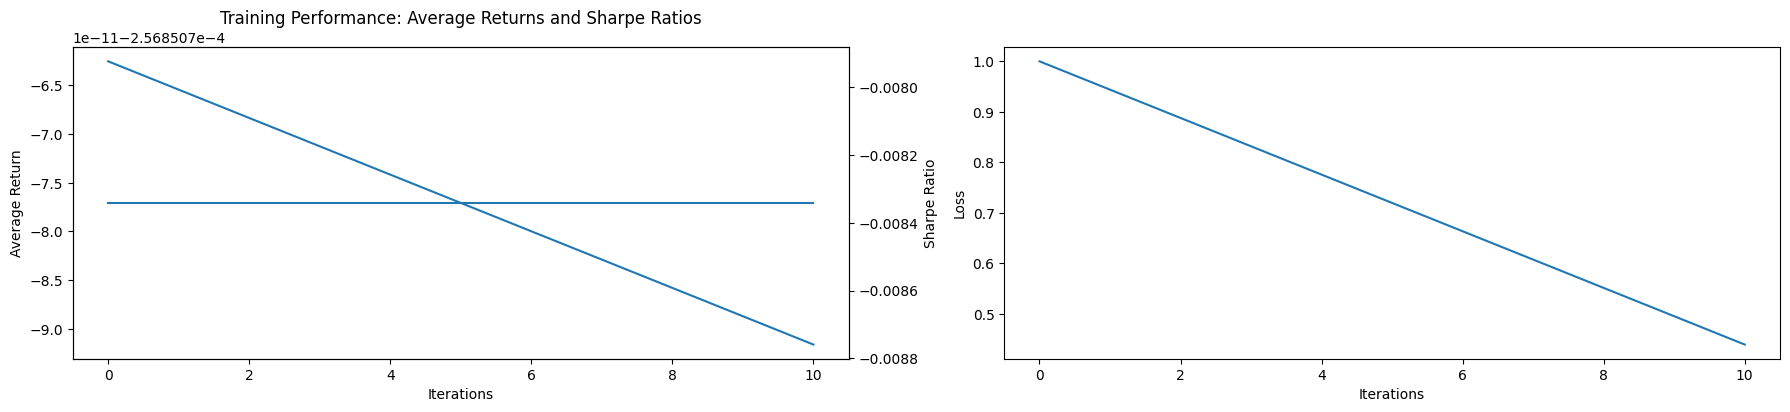

In [11]:
sim.plot_performance(metrics)

# Conclusion

CONCLUDE

## References

- [TensorFlow Agents](https://www.tensorflow.org/agents/overview)
- [Open Gym AI Github](https://github.com/openai/gym)
- [Greg et al, OpenAI Gym, (2016)](https://arxiv.org/abs/1606.01540)
- [Théate, Thibaut, and Damien Ernst. "An application of deep reinforcement learning to algorithmic trading." Expert Systems with Applications 173 (2021): 114632.](https://www.sciencedirect.com/science/article/pii/S0957417421000737)
- [Remote development in WSL](https://code.visualstudio.com/docs/remote/wsl-tutorial)
- [NVIDIA Driver Downloads](https://www.nvidia.com/Download/index.aspx)
- [CUDA Toolkit](https://developer.nvidia.com/cuda-toolkit-archive)
- [TensorRT for CUDA](https://docs.nvidia.com/deeplearning/tensorrt/archives/index.html#trt_7)

## Github

Article here is also available on [Github](https://github.com/adamd1985/pairs_trading_unsupervised_learning)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/deep-q-rl-with-algorithmic-trading-policy)

Google Collab available [here](https://colab.research.google.com/drive/1FTj65b2DA8oFgvmmjLc0XIwtII32PwcM?usp=sharing)

## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.